In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

numpyro.set_host_device_count(4)

/Users/omarfsosa/.pyenv/versions/3.8.10/envs/numpyro/lib/python3.8/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
numpyro.__version__

'0.10.0'

In [5]:
@jax.jit
def richards(t, theta1, theta2, theta3, xi):
    den = 1 + xi * jnp.exp(-theta2 * (t - theta3))
    return theta1 / den ** (1/xi)

drichards = jax.jit(jax.vmap(jax.grad(richards, argnums=0), in_axes=(0, None, None, None, None)))

In [6]:
t = jnp.arange(200, dtype=jnp.float32)
theta1 = 1.0
theta2 = 0.1
theta3 = 100.0
xi = 2.0

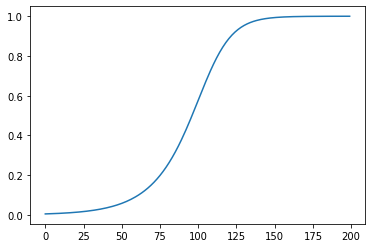

In [7]:
plt.plot(t, richards(t, theta1, theta2, theta3, xi))

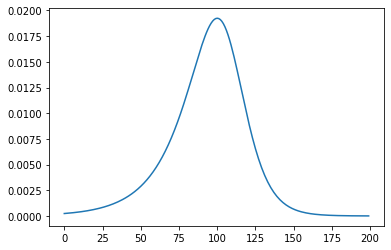

In [8]:
plt.plot(t, drichards(t, theta1, theta2, theta3, xi))

In [19]:
def model(t, y=None):
    population = 10e3
    theta1 = numpyro.sample("theta1", dist.Beta(3, 10))
    theta2 = numpyro.sample("theta2", dist.Exponential(rate=10))
    theta3 = numpyro.sample("theta3", dist.Normal())
    theta3 = 90 + 30 * theta3
    xi = numpyro.sample("xi", dist.Gamma(3, 2))
    mu = population * drichards(t, theta1, theta2, theta3, xi)
    numpyro.deterministic("mu", mu)
    numpyro.sample("y", dist.Poisson(mu), obs=y)

In [20]:
prior = Predictive(model, num_samples=100)

In [21]:
prior_samples = prior(jax.random.PRNGKey(0), t=t)

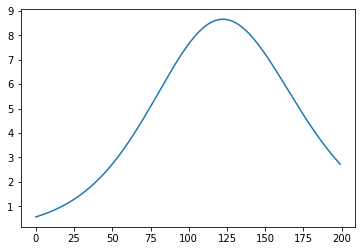

In [22]:
plt.plot(t, prior_samples['mu'][0])

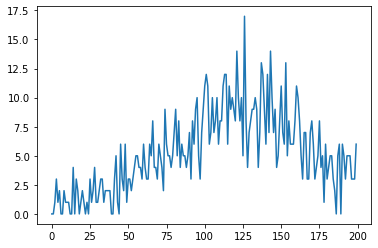

In [23]:
plt.plot(t, prior_samples['y'][0])

In [24]:
"""Visualization tools"""
import matplotlib.pyplot as plt
import numpy as np


def spaghetti_plot(
    x, y, n_samples=20, indices=None, ax=None, plot_kwargs=None
):
    """
    Plots x against a few picked examples of y.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array.
        First axis (0) is the samples axis.
        Second axis (1) are the values for the y axis.
    n_samples: int (default 20)
        How many sampled values to plot. `n_samples` are
        selected uniformly at random.
    indices: 1d array
        Indices of the specific samples that will be selected
        for plotting.
    ax: matplotlib.Axes
        The axes where the figure will be plotted.
    plot_kwargs: dict
        Extra arguments passed to `plt.plot`

    Returns
    -------
    matplotlib.Axes

    """
    has_indices = indices is not None
    has_samples = bool(n_samples)
    if has_indices == has_samples:
        _msg = "Exactly one of `n_samples` or `indices` must be specified"
        raise ValueError(_msg)

    if has_samples:
        indices = np.random.choice(range(y.shape[0]), n_samples)

    ax = ax or plt.gca()
    for idx in indices:
        ax.plot(x, y[idx], **(plot_kwargs or {}))

    return ax


def ribbon_plot(
    x,
    y,
    n_ribbons=10,
    percentile_min=1,
    percentile_max=99,
    ribbon_color="r",
    plot_median=True,
    line_color="k",
    ax=None,
    fill_kwargs=None,
    line_kwargs=None,
):
    """
    Make a ribbon plot that shows the different quantiles of the
    distribution of y against x.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array
    n_ribbons: int (default 10)
        How many quantiles to show
    percentile_min: float, between 0 and 50
        The lowest percentile to be shown
    percentile_max: float between 50 and 100
        The highest percentile to show.
    ribbon_color: str (default 'r')
        Color for the ribbons. Must be a valid expression for
        matplotlib colors.
    plot_median: bool (default True)
        Whether or not to plot a line for the 50% percentile
    line_color: str (default 'k')
        Color to use for the median.
    ax: matplotlib.Axes
        Where to plot the figure.
    fill_kwargs: dict
        Extra arguments passed to `plt.fill_between`.
        Controls the aspect of the ribbons.
    line_kwargs: dict
        Extra arguments to be passed to `plt.plot`.
        Controls the aspect of the median line.

    Returns
    -------
    matplotlib.Axes
    """
    perc1 = np.percentile(
        y,
        np.linspace(percentile_min, 50, num=n_ribbons, endpoint=False),
        axis=0,
    )
    perc2 = np.percentile(
        y, np.linspace(50, percentile_max, num=n_ribbons + 1)[1:], axis=0
    )
    fill_kwargs = fill_kwargs or {}
    line_kwargs = line_kwargs or {}
    alpha = fill_kwargs.pop("alpha", 1 / n_ribbons)
    ax = ax or plt.gca()
    plt.sca(ax)

    # fill ribbons
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(
            x, p1, p2, alpha=alpha, color=ribbon_color, **(fill_kwargs or {})
        )

    if plot_median:
        plot_func = plt.step if fill_kwargs.pop("step", None) else plt.plot
        plot_func(
            x, np.median(y, axis=0), color=line_color, **(line_kwargs or {})
        )

    return plt.gca()

<AxesSubplot:>

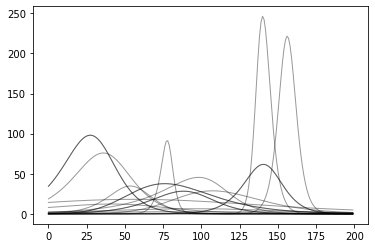

In [25]:
spaghetti_plot(t, prior_samples['mu'], plot_kwargs={'lw': 1, 'c': 'k', "alpha": 0.4})

## Example

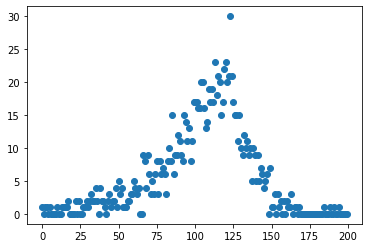

In [34]:
true_y = prior_samples['y'][6]
plt.plot(t, true_y, marker='o', lw=0)

In [37]:
mcmc = MCMC(NUTS(model=model), num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')

In [38]:
seed = jax.random.PRNGKey(1)

In [50]:
num_obs = 70

In [51]:
mcmc.run(seed, t=t[:num_obs], y=true_y[:num_obs])

sample: 100%|█| 2000/2000 [00:02<00:00, 937.93it/s, 63 steps of size 5.84e
sample: 100%|█| 2000/2000 [00:00<00:00, 5870.25it/s, 3 steps of size 6.39e
sample: 100%|█| 2000/2000 [00:00<00:00, 5815.41it/s, 63 steps of size 5.21
sample: 100%|█| 2000/2000 [00:00<00:00, 5677.64it/s, 63 steps of size 5.62


In [52]:
samples = mcmc.get_samples()

In [53]:
predictive = Predictive(model, posterior_samples=samples)

In [54]:
pred_samples = predictive(jax.random.PRNGKey(2), t=t)

<AxesSubplot:>

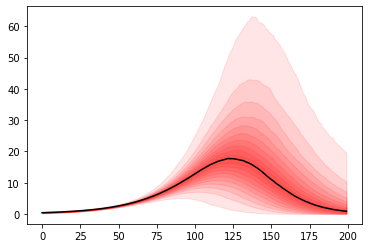

In [55]:
ribbon_plot(t, pred_samples['mu'])

In [88]:
%config InlineBackend.figure_format = "retina"

In [90]:
plt.rcParams["font.size"] = 16

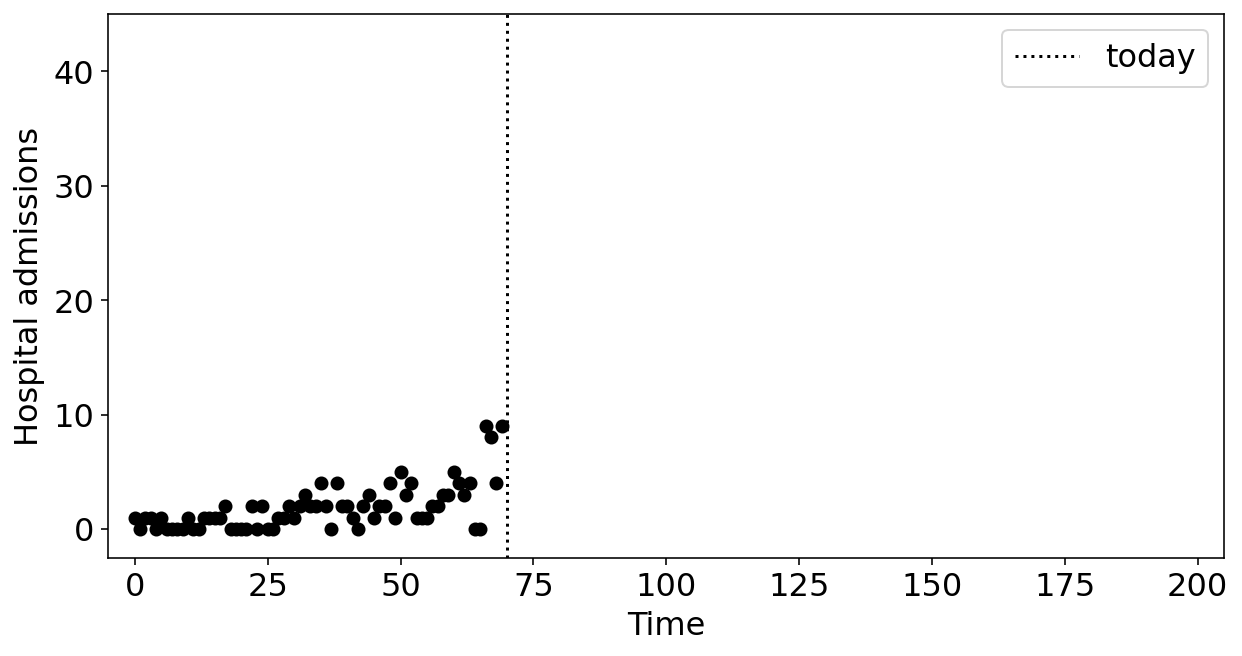

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(t[:num_obs], true_y[:num_obs], marker='o', lw=0, color='k', alpha=1)
# plt.plot(t[num_obs:], true_y[num_obs:], marker='o', lw=0, color='gray', alpha=0.5)
# ribbon_plot(t[:num_obs], pred_samples['y'][:, :num_obs], ribbon_color='C0', percentile_min=5, percentile_max=95)
# ribbon_plot(t[num_obs:], pred_samples['y'][:, num_obs:], ribbon_color='gray', percentile_min=5, percentile_max=95)
plt.xlim(-5, 205)
plt.ylim(-2.5, 45)
plt.axvline(num_obs, linestyle=':', color='k', label='today')
plt.xlabel("Time")
plt.ylabel("Hospital admissions")
plt.legend()

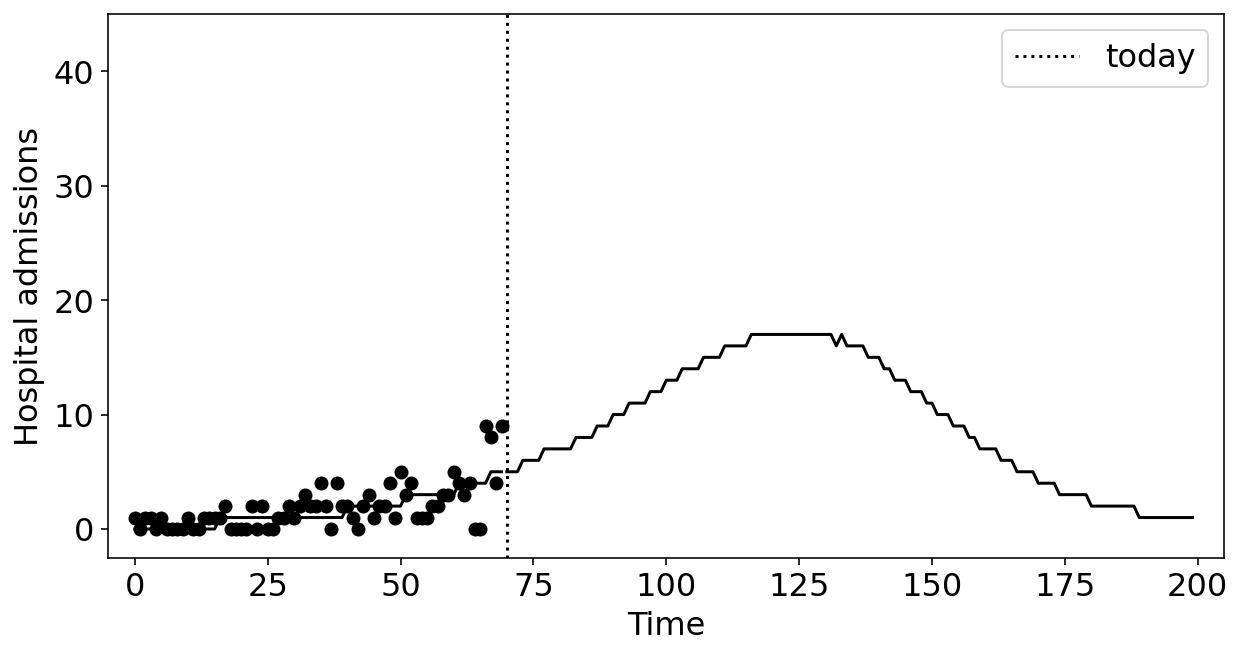

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(t[:num_obs], true_y[:num_obs], marker='o', lw=0, color='k', alpha=1)
# plt.plot(t[num_obs:], true_y[num_obs:], marker='o', lw=0, color='gray', alpha=0.5)
ribbon_plot(t[:num_obs], pred_samples['y'][:, :num_obs], ribbon_color='none', percentile_min=5, percentile_max=95)
ribbon_plot(t[num_obs:], pred_samples['y'][:, num_obs:], ribbon_color='none', percentile_min=5, percentile_max=95)
plt.xlim(-5, 205)
plt.ylim(-2.5, 45)
plt.axvline(num_obs, linestyle=':', color='k', label='today')
plt.xlabel("Time")
plt.ylabel("Hospital admissions")
plt.legend()

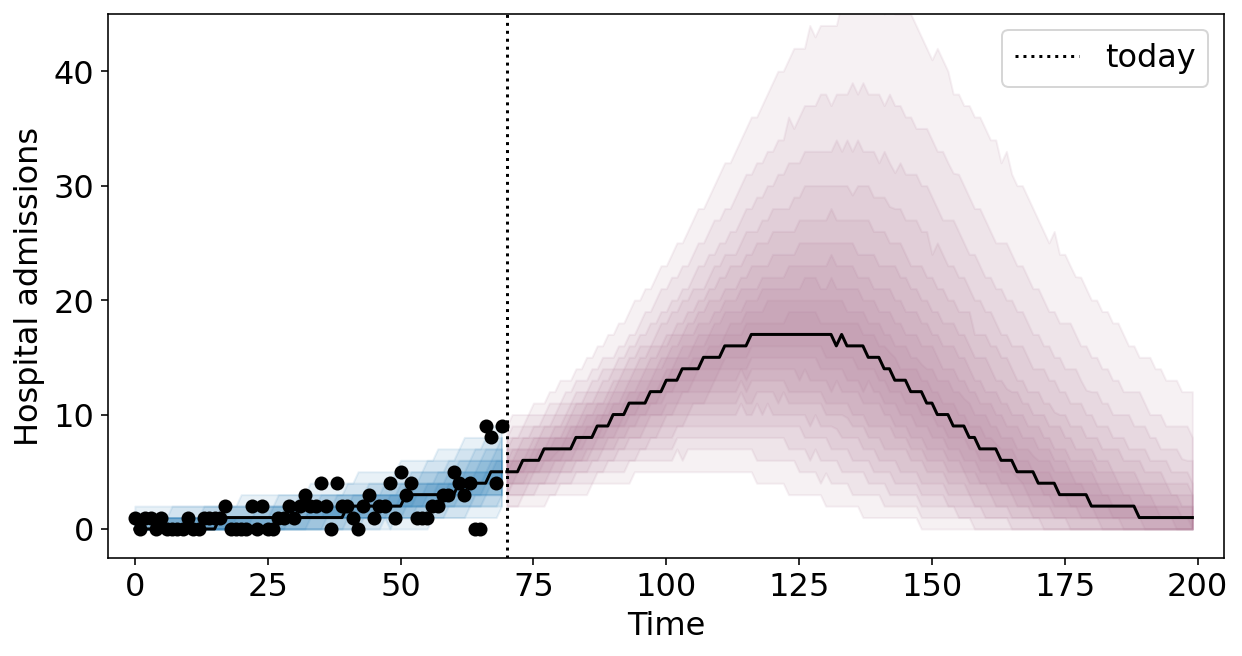

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(t[:num_obs], true_y[:num_obs], marker='o', lw=0, color='k', alpha=1)
# plt.plot(t[num_obs:], true_y[num_obs:], marker='o', lw=0, color='gray', alpha=0.5)
ribbon_plot(t[:num_obs], pred_samples['y'][:, :num_obs], ribbon_color='C0', percentile_min=5, percentile_max=95)
ribbon_plot(t[num_obs:], pred_samples['y'][:, num_obs:], ribbon_color="#ad7693", percentile_min=5, percentile_max=95)
plt.xlim(-5, 205)
plt.ylim(-2.5, 45)
plt.axvline(num_obs, linestyle=':', color='k', label='today')
plt.xlabel("Time")
plt.ylabel("Hospital admissions")
plt.legend()

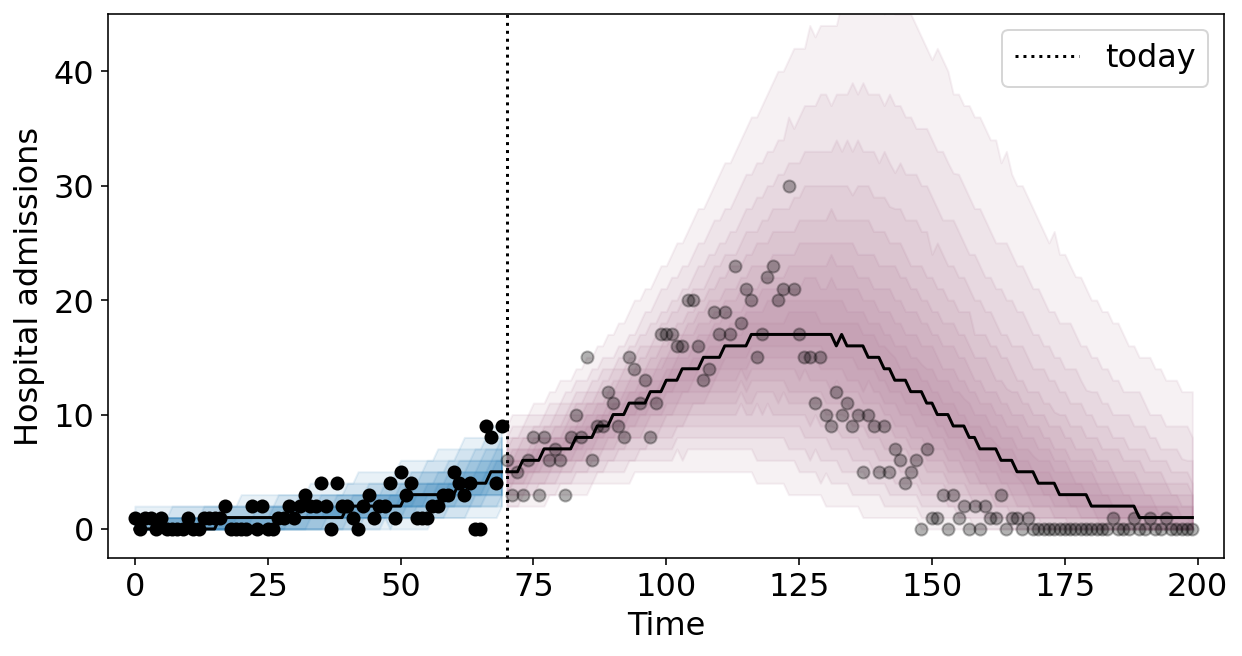

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(t[:num_obs], true_y[:num_obs], marker='o', lw=0, color='k', alpha=1)
plt.plot(t[num_obs:], true_y[num_obs:], marker='o', lw=0, color='k', alpha=0.3)
ribbon_plot(t[:num_obs], pred_samples['y'][:, :num_obs], ribbon_color='C0', percentile_min=5, percentile_max=95)
ribbon_plot(t[num_obs:], pred_samples['y'][:, num_obs:], ribbon_color="#ad7693", percentile_min=5, percentile_max=95)
plt.xlim(-5, 205)
plt.ylim(-2.5, 45)
plt.axvline(num_obs, linestyle=':', color='k', label='today')
plt.xlabel("Time")
plt.ylabel("Hospital admissions")
plt.legend()